In [257]:
from tqdm.notebook import tqdm

import numpy as np
from numpy import dot, power, argmin
from numpy.linalg import inv, norm
from numpy.random import randn

import scipy.io as sio
from scipy.optimize import minimize, nnls

from sklearn.linear_model import Lasso

import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import cross_val_score as CVS
from sklearn.model_selection import KFold as CV
from sklearn.metrics import confusion_matrix as CM
from sklearn.neighbors import KNeighborsClassifier as KNN

# **Part 1: Regression (Spectral Unmixing)**

## **(A) Abundnance Maps and Recosntruction Errors**

In [11]:
Salinas = sio.loadmat("/content/Salinas_cube.mat")
HSI = Salinas["salinas_cube"] #Salinas HSI : 220x120x204

ends = sio.loadmat("/content/Salinas_endmembers.mat") # Endmember's matrix: 204x7
endmembers = ends["salinas_endmembers"]

# Perform unmixing for the pixels corresponding to nonzero labels
ground_truth = sio.loadmat("/content/Salinas_gt.mat")
labels = ground_truth["salinas_gt"]

* First, we explore pixels' labels to find out how many have a non-zero label, a zero label, and a negative label.

In [ ]:
N_nonzero, N_zero, N_negative = np.sum(labels != 0), np.sum(labels == 0), np.sum(labels < 0)
print(f"number of non-zero pixels\t: {N_nonzero}\nnumber of zero pixels\t\t: {N_zero}\nnumber of negative pixels\t: {N_negative}")

number of non-zero pixels	: 16929
number of zero pixels		: 9471
number of negative pixels	: 0


* The function `model` is used to organize the models' formulation procedures. Depending on the model's identifying code (see inline comments in the code cell, below), we return that model's parameter estimates, in order to fill the related parts of `thetas`, i.e., the array holding all relevant information about the parameters' estimates, for all of the models listed below. Note that this function will be repeatedly called, inside the main iterative process, for every non-zero, non-negative pixel of the HSI.

In [ ]:
def model(X, y, model_id):

  if (model_id == 0):                                # ols
    return inv(dot(X.T, X)).dot(X.T).dot(y)

  elif (model_id == 1):                              # ols + sum to one
    return minimize(objective_function,
                    x0 = init_b,
                    args = (X, y),
                    method = "SLSQP",
                    constraints = sum_to_one).x

  elif (model_id == 2):                              # ols + non-negative
    return minimize(objective_function,
                    x0 = init_c,
                    args = (X, y),
                    method = "SLSQP",
                    bounds = non_negative).x

  elif (model_id == 3):                              # ols + sum to one + non-negative
    return minimize(objective_function,
                    x0 = init_d,
                    args = (X, y),
                    method = "SLSQP",
                    constraints = sum_to_one,
                    bounds = non_negative).x

  else:                                              # ols + lasso
    return (Lasso(alpha = 0.01,
                  positive = True,
                  fit_intercept = False,
                  max_iter = 1e7)
            .fit(X,y)
            .coef_)

* The function that is shown below, `calc_avg_rec_err`, will be used later, after the models' parameters estimation, in order to calculate the average reconstruction error of each model. You can find useful information, regarding its functioning, by reading the comments.

In [ ]:
def calc_avg_rec_err(X, thetas, model_id):

  # this is the abundance map for the given mode_id, whose shape is: (M, N, E) = (220, 120, 7)
  abundance_map = thetas[:, :, :, model_id]

  # this is the reshaped abundance map, whose shape is: (E, M x N) = (7, 220 x 120) = (7, 26400)
  abundance_map = np.reshape(abundance_map, (M * N, E)).T
  # we reshape the initial abundance map, so that we can leverage the useful vectorization properties of numpy's
  # and calculate the mean reconstruction error for the whole image, all at once

  # X: (204, 7) x abundance_map: (7, 26400) = X.dot(abundance_map).T: (26400, 204). please, note the transposition.
  y_estimated = X.dot(abundance_map).T
  # y_estimated is a matrix (M x N = 26400, L = 204), whose rows refer to the pixels (M x N = 26400) of HSI,
  # and columns refer to the different spectral bands (L = 204)

  # next, we reshape the labels mask from (M x N) = (220, 120) to (M x N,) = (26400,)
  # we will use this boolean vector, in order shut down the importance the zero or (not exclusive) negative label pixels of HSI
  # have to the calculation of the average reconstruction error.
  norm_mask = np.reshape(labels_mask, (M * N))

  # note, here, that this masking process by itself is not enough, because even though we transpassed the zero or negative label pixels,
  # we risk to calculate the average reconstruction error by dividing with the total number of pixels, including those with zero or negative label.
  # to resolve this issue, we calculate the average by deviding only by the total number of non-zero and non-negative pixels.
  # also, we reshape HSI, so that it comes to the form: (M, N, L) = (220, 120, 204) ---> (M x N, L) = (26400, 204)
  # this, will let us calculate the average reconstruction error easier, with a simple numpy subtraction.
  y_truth = np.reshape(HSI, (M * N, L))
  avg_rec_err = np.sum(power(norm(y_truth - y_estimated, axis = 1), 2) * norm_mask) / N_nonzero

  return avg_rec_err

* Below, before starting the estimation process, we set up some global variables that will be used in the course of this part.
* Note, also, that we've created a boolean mask, called `labels_mask`, which will be used to filter out all those pixels that have a zero or negative label. With the aid of this mask, if you saw in `calc_avg_rec_err` function, we properly calculated the average reconstruction error by ruling out all those cases, whose label is not appropriate.
* Lastly, as you can see, below, we have also created the `numpy.ndarray` that will be used to store the models' parameters estimates, called `thetas`. Here, it is important to see that `thetas` include spots for all pixels of the HSI, including those with zero or negative labels. The parts of the array that have been dedicated for such pixels, are not filled with parameter estimates, and this is achieved with the use of `labels_mask`. However, these parts, just for the sake of completeness, are included into the final abundance maps of the models. The way to discriminate those parts, is to check if all of their values are zeros, and if so, then they refer to pixels with zero or negative label.

In [12]:
(M, N, L), E = HSI.shape, endmembers.shape[1]
labels_mask = labels > 0
thetas = np.zeros((M, N, E, 5))
X = endmembers

* Now, we devote some code in order to set up the optimization procedures for the cases $(b)$, $(c)$, and $(d)$. In all these cases, we need to minimize the objective function $||y-Xθ||^{2}$ with respect to $θ$, and under the following constraints:
 * $(b)$ Least Squares + Sum-to-One: $\sum_{e=1} ^{Ε} θ_{e}=1$
 * $(c)$ Least Squares + Non-negativity: $θ_{e}≥0 \ ∀ \ e=\{1,...,E\}$
 * $(d)$ Least Squares + Sum-to-One + Non-negativity: $\sum_{e=1} ^{Ε} θ_{e}=1$ and $θ_{e}≥0 \ ∀ \ e=\{1,...,E\}$
* In the code cells, below, we will formulate these three optimization problems, using `scipy.optimize`, and bring them to such form, so that they can be easily implemented in the general algorithmic procedure that we've constructed below.

In [ ]:
# this is the objective function
# this is for all cases (b), (c), and (d)
objective_function = lambda theta, X, y: power(norm(y - X.dot(theta)), 2)

# this is sum-to-one constraint the way we can state to scipy's optimizer
# that we need our solution's components, which are 7 in total, to sum to 1
# this is for cases (b) and (d)
sum_to_one = ({"type": "eq", "fun": lambda theta: np.sum(theta) - 1})

# this is the non-negativity constrain, which is imposed to scipy's optimizer only as a list of tuples,
# where each tuple refers to the constricted space of feasible solutions for each of theta's components.
# that's why we use a list of 7 tuples; because our thetas are 7-D.
# this is for cases (c) and (d)
non_negative = [(0, float("inf")) for e in range(E)]

# next are some initialization schemas for our solution's vector
init_a = randn(7) # random (a)
init_b = init_a / np.sum(init_a) # random + sum-to-one (b)
init_c = np.where(init_a < 0, -1 * init_a, init_a) # random + non-negativity (c)
init_d = np.where(init_a < 0, -1 * init_a, init_a) / np.sum(init_a) # random + sum-to-one + non-negativity (d)

* In the code cell, below, we create the abundance map of each model. As you can see, for each of the five models (`model_id`), we iterate over the pixels of HSI, and only for those pixels that have a non-zero, non-negative label (we filter the pixels with `labels_mask`), we estimate the corresponding model's parameters, and store them in the regarding part of `thetas`.

In [ ]:
# MAIN ITERATIVE PROCESS
for model_id in tqdm(range(5)):
  for m in tqdm(range(M)):
    for n in tqdm(range(N)):
      if labels_mask[m, n]:
        y = np.expand_dims(HSI[m, n, :], axis = -1)
        thetas[m, n, :, model_id] = np.squeeze(model(X, y, model_id))

* Then, for each of the above models' parameter estimates, which we've stored in `thetas`, we compute the average reconstruction error, and store them in the `reconstruction_errors` dictionary. Also, we extract the corresponding cubes (M = 220 × N = 120 × E = 7), corresponding to the abundance maps of each model, and store them into the `abundance_maps` dictionary.

In [ ]:
abundance_maps, reconstruction_errors = {}, {}
for model_id in range(5):
  abundance_maps[model_id] = thetas[:, :, :, model_id]
  reconstruction_errors[model_id] = calc_avg_rec_err(X, thetas, model_id)

# 0: ols
# 1: sum-to-one
# 2: non-negativity
# 3: sum-to-one + non-negativity
# 4: lasso

## **(B) Results**

Exception ignored in: <function tqdm.__del__ at 0x7fc5db39e4c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/usr/local/lib/python3.8/dist-packages/tqdm/notebook.py", line 288, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


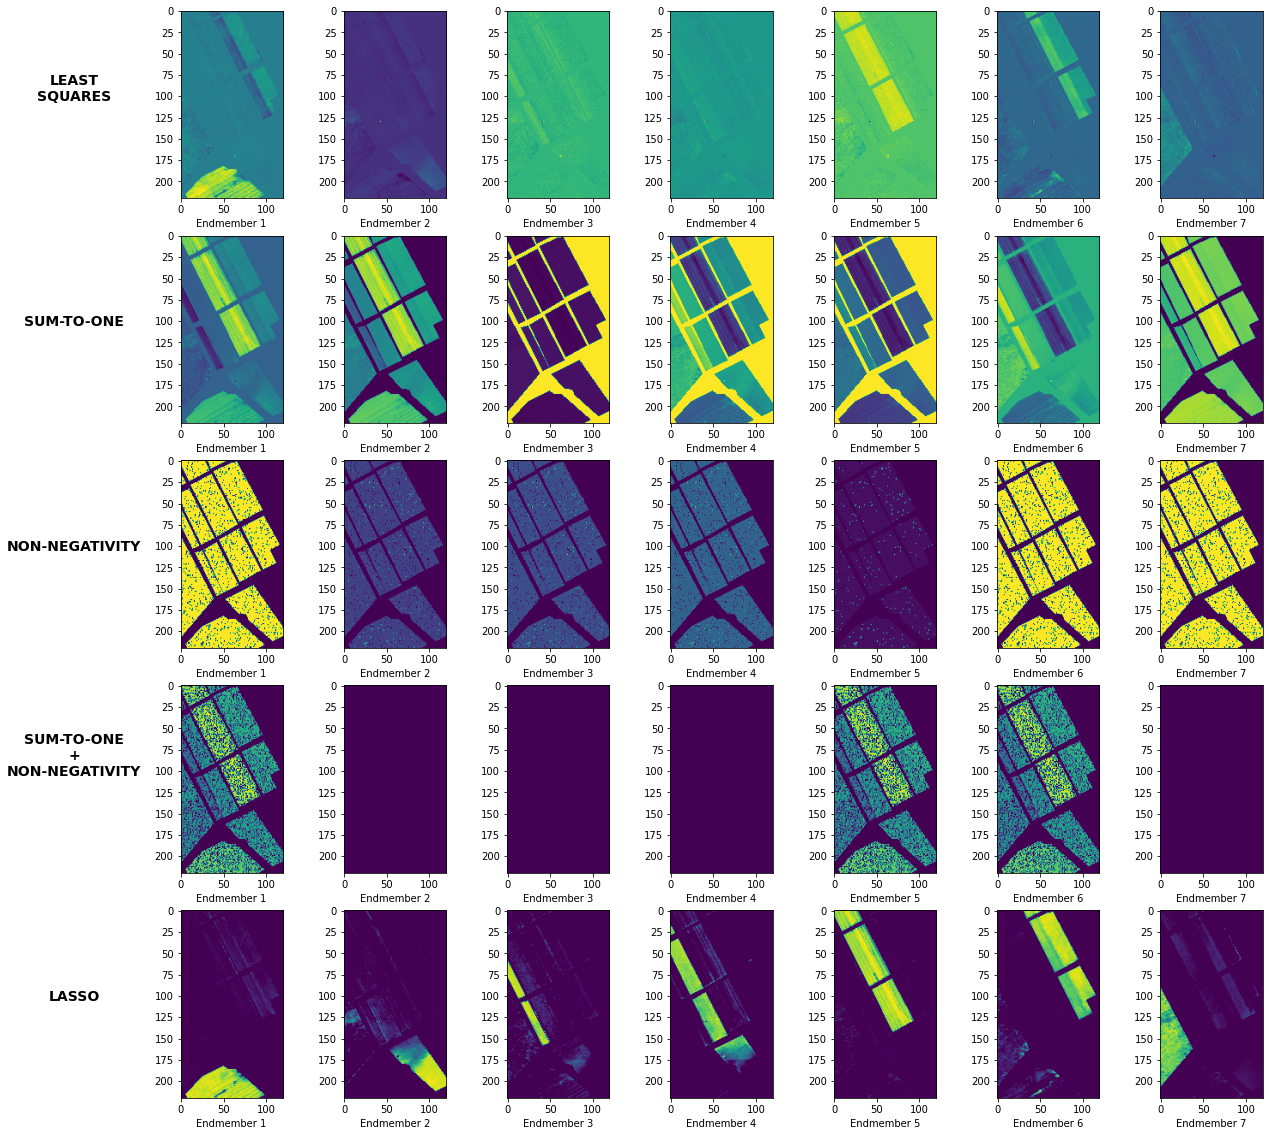

In [ ]:
models = ["LEAST\nSQUARES", "SUM-TO-ONE", "NON-NEGATIVITY", "SUM-TO-ONE\n+\nNON-NEGATIVITY", "LASSO"]
fig, axs = plt.subplots(ncols = 7, nrows = 5, figsize = (20, 20))
for model_id in range(axs.shape[0]):
  for e in range(axs.shape[1]):
    axs[model_id, e].imshow(thetas[:, :, e, model_id])
    axs[model_id, e].set_xlabel(f"Endmember {e + 1}")
  axs[model_id, 0].set_ylabel(f"{models[model_id]}", fontsize = 14, fontweight = "bold", rotation = 360, labelpad = 80)

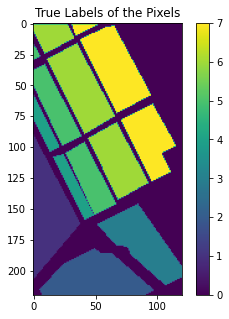

In [ ]:
plt.figure(figsize = (5, 5))
plt.imshow(labels)
plt.title("True Labels of the Pixels")
plt.colorbar()
plt.show()

* By comparing the models' abundance maps with the true labels of the pixels' image, we would like to see each abundance map of each endmember to represent with a corresponding color, only those regions of the image that relate to the endmember they are referring to. You can see, above, it's not clear as of which model acheives the best performance at that, but according to the reconstruction errors, it seems that Least Squares has the lowest, as you have already seen.

# **Part 2: Classification (Image Classification)**

In [ ]:
Salinas_labels = sio.loadmat('classification_labels_Salinas.mat')
Training_Set = (np.reshape(Salinas_labels['training_set'],(120,220))).T
Test_Set = (np.reshape(Salinas_labels['test_set'],(120,220))).T
Operational_Set = (np.reshape(Salinas_labels['operational_set'],(120,220))).T

* As you can see, we already had our data set splitted into training, testing, and operational data subsets. Yet, each of these, need to be splitted further into their $X$ and $y$ components, which refer to the data ($X$) that will be utilized by the algorithms, in order to fit their mechanisms accordingly and try to predict the true labels ($y$). As you can see, we haven't done that yet.
* To get a better intuition over what we are trying to do, consider the following rationale:
 * The exercise has already splitted the initial data set into three data subsets, i.e., training, testing, operational. That is, given the HSI, which you can imagine as a (M, N, L) = (220, 120, 204) cube, the code, above, has attributed each of the pixels' spectral signatures (1, 1, L) = (1, 1, 204) to one of the three aforementioned data subsets. These structures referred to $y$, altogether, in the **spectral unmixing part**.
 * However, in this part, each of these pixels' spectral signatures refer to both $X$ and $y$. In particular, the $X$ part, are the spectral signatures themselves, and the $y$ part are just the labels that these spectral signatures correspond to. Thus, in order to get $y$, in our case, we need to refer to the data subsets that have been already given to us from the exercise (`Training_Set`, `Test_Set`, and `Operational_Set`). These data subsets, contain iformation **only** for the true labels of the corresponding spectral signatures. In order to get their $X$ part, we need to extract their spectral signatures from the HSI.
 * To do that, we have created a specific function (see below), called `prepair_X_y`. It's important to note, also mentioned in the in-line comments in the function, that we discard the pixels associated with a zero label.

In [141]:
def prepair_X_y(data):
  # firstly, we start with the unfiltered versions of X, y
  X_unmasked = np.reshape(HSI, (M * N, L))
  y_unmasked = np.reshape(data, (M * N,))
  # secondly, we create a boolean mask, which is true only for those pixels of the y_unmasked that have a non-zero label, and false elsewhere
  mask = (y_unmasked != 0)
  # lastly, we apply the boolean mask to the unmasked versions of X, y in order to derive their masked forms, which in effect are filtered
  # out of all those pixels that are associated with a zero label
  X_masked = X_unmasked[mask, :]
  y_masked = y_unmasked[mask]
  return X_masked, y_masked

* Next, let's prepare our $X$ and $y$, for each data subset: `Training_Set`, `Testing_Set`, and `Operational_Set`.

In [208]:
(      X_train,       y_train)  =      prepair_X_y(Training_Set)
(       X_test,        y_test)  =          prepair_X_y(Test_Set)
(X_operational, y_operational)  =   prepair_X_y(Operational_Set)

## **(A) Generalization Errors, Confusion Matrices, and Success Rates using 10-Fold Cross Validation**

### **Gaussian Naive Bayes Classifier**

#### **Generalization Error**

In [148]:
GNB_SCORES = CVS(GNB(), X_train, y_train, cv = 10)
GNB_ERRORS = 1 - GNB_SCORES

In [150]:
print("Gaussian Naive Bayes Classifier")
print("===============================")
print(f"Generalization Error\t: {round(np.mean(GNB_ERRORS), 3)}")
print("-------------------------------")
print(f"Standard Deviation\t: {round(np.std(GNB_ERRORS), 3)}")
print("-------------------------------")

Gaussian Naive Bayes Classifier
Generalization Error	: 0.026
-------------------------------
Standard Deviation	: 0.016
-------------------------------


#### **Confusion Matrix and Success Rate**

In [151]:
GNB_PREDICTIONS = GNB().fit(X_train, y_train.reshape(-1)).predict(X_test)
GNB_CM = CM(y_test, GNB_PREDICTIONS)
GNB_SR = np.trace(GNB_CM) / np.sum(GNB_CM)

In [159]:
print("Gaussian Naive Bayes Classifier")
print("===============================")
print(f"        Confusion Matrix")
print(GNB_CM)
print("-------------------------------")
print(f"Success Rate            : {round(GNB_SR, 3)}")
print("-------------------------------")

Gaussian Naive Bayes Classifier
        Confusion Matrix
[[545   0   0   0   0   0   3]
 [  5 512   0   0   0   0   0]
 [  0   0 470   0  42   0   0]
 [  0   0   0 210   4   0   0]
 [  0   0  12   4 547   0   0]
 [  1   0   2   0   0 995   0]
 [  6   0   0   0   0   0 874]]
-------------------------------
Success Rate            : 0.981
-------------------------------


### **k-NN Classifier**

#### **Generalization Error**

In [160]:
KNN_SCORES = CVS(KNN(n_neighbors = 7), X_train, y_train, cv = 10)
KNN_ERRORS = 1 - KNN_SCORES

In [165]:
print("k-NN Classifier")
print("===============================")
print(f"Generalization Error\t:  {round(np.mean(KNN_ERRORS), 3)}")
print("-------------------------------")
print(f"Standard Deviation\t: {round(np.std(KNN_ERRORS), 3)}")
print("-------------------------------")

k-NN Classifier
Generalization Error	:  0.01
-------------------------------
Standard Deviation	: 0.014
-------------------------------


#### **Confusion Matrix and Success Rate**

In [162]:
KNN_PREDICTIONS = KNN(n_neighbors = 7).fit(X_train, y_train).predict(X_test)
KNN_CM = CM(y_test, KNN_PREDICTIONS)
KNN_SR = np.trace(KNN_CM) / np.sum(KNN_CM)

In [174]:
print("        k-NN Classifier")
print("===============================")
print(f"        Confusion Matrix")
print(KNN_CM)
print("-------------------------------")
print(f"Success Rate            : {round(KNN_SR, 3)}")
print("-------------------------------")

        k-NN Classifier
        Confusion Matrix
[[547   0   0   0   0   0   1]
 [  0 516   0   0   0   0   1]
 [  0   0 510   0   2   0   0]
 [  0   0   0 214   0   0   0]
 [  0   0   8   1 552   2   0]
 [  0   0   0   0   0 998   0]
 [  2   0   0   0   0   0 878]]
-------------------------------
Success Rate            : 0.996
-------------------------------


### **Bayesian Classifier**

#### **Generalization Error**

In [175]:
QDA_SCORES = CVS(QDA(), X_train, y_train, cv = 10)
QDA_ERRORS = 1 - QDA_SCORES

In [176]:
print("Bayesian Classifier")
print("===============================")
print(f"Generalization Error\t: {round(np.mean(QDA_ERRORS), 3)}")
print("-------------------------------")
print(f"Standard Deviation\t: {round(np.std(QDA_ERRORS), 3)}")
print("-------------------------------")

Bayesian Classifier
Generalization Error	: 0.034
-------------------------------
Standard Deviation	: 0.006
-------------------------------


#### **Confusion Matrix and Success Rate**

In [177]:
QDA_PREDICTIONS = QDA().fit(X_train, y_train).predict(X_test)
QDA_CM = CM(y_test, QDA_PREDICTIONS)
QDA_SR = np.trace(QDA_CM) / np.sum(QDA_CM)

In [186]:
print("       Bayesian Classifier")
print("===============================")
print(f"        Confusion Matrix")
print(QDA_CM)
print("-------------------------------")
print(f"Success Rate            : {round(QDA_SR, 3)}")
print("-------------------------------")

       Bayesian Classifier
        Confusion Matrix
[[548   0   0   0   0   0   0]
 [  0 517   0   0   0   0   0]
 [  0   0 512   0   0   0   0]
 [  0   0   0 125  89   0   0]
 [  0   0   3   0 558   2   0]
 [  0   0   0   0   0 998   0]
 [  0   0   0   0   0   0 880]]
-------------------------------
Success Rate            : 0.978
-------------------------------


### **Minimum Euclidean Distance Classifier**

* In the code cell, below, we create the k-Fold Cross Validation schema that will be used to calculate the generalization error, only for the case of the Minimum Euclidean Distance Classifier (MED).
* Before doing so, we also define some useful helper functions that will be used during the process. These are defined, and described, in the code cells below as well.
 * In brief, the function `get_class_means` caclulates the mean vectors for each of the classes, and stores them into an `numpy.ndarray` of size (E, L) = (7, 204). This function receives the arguments `X` and `y`, which refer to the ***training*** data subset of each of the k folds of the cross validation procedure.
 * The function `classify_X`, then, calculates the euclidean distance of each vector of the corresponding ***testing*** data subset from each of the mean vectors that have been calculated from the `get_class_means`, and for each one of those testing vectors keeps the class, from which the minimum distance is recorded.

In [287]:
def get_class_means(X, y):
  class_means = np.zeros((E, L))
  for e in range(E):
    class_mask = (y == (e + 1))
    class_means[e, :] = np.mean(X[class_mask, :], axis = 0) # average by columns, i.e., spectral bands
  return class_means

In [288]:
def classify_X(X, class_means):
  nrows = X.shape[0]
  y_pred_X = np.zeros((nrows,))
  for nrow in range(nrows):
    x = X[nrow, :]
    x_dist_means = norm(class_means - x, axis = 1)
    y_pred_X[nrow] = argmin(x_dist_means)
  y_pred_X = (y_pred_X + 1).astype(int)
  return y_pred_X

In [ ]:
cv = CV(n_splits = 10)

prob_errs = []

# train_picks, test_picks refer to random indices of X_train and y_train
# these random picks of indices are generated, 10 times in total, from the cv.split(X_train, y_train) generator 
for train_picks, test_picks in cv.split(X_train, y_train):

  # get the randomly picked parts of X_train, y_train
  (X_train_CV, y_train_CV) = X_train[train_picks, :], y_train[train_picks]
  ( X_test_CV,  y_test_CV) =  X_train[test_picks, :],  y_train[test_picks]

  # get class means
  class_means = get_class_means(X_train_CV, y_train_CV)

  # get classifications for each testing vector (rows) of X_test
  y_pred = classify_X(X_test_CV, class_means)

  # calculate probability error for this fold, and store it into prob_errs
  prob_err = np.sum((y_pred - y_test_CV) != 0) / len(test_picks)
  prob_errs.append(prob_err)

#### **Generalization Error**

In [318]:
print("Minimum Euclidean Distance Classifier")
print("=====================================")
print(f"Generalization Error          : {round(np.mean(prob_errs), 3)}")
print("-------------------------------------")
print(f"Standard Deviation            : {round(np.std(prob_errs), 3)}")
print("-------------------------------------")

Minimum Euclidean Distance Classifier
Generalization Error          : 0.055
-------------------------------------
Standard Deviation            : 0.077
-------------------------------------


#### **Confusion Matrix and Success Rate**

In [322]:
class_means = get_class_means(X_train, y_train)
y_pred = classify_X(X_test, class_means)
MDE_CM = CM(y_test, y_pred)
MDE_SR = np.trace(MDE_CM) / np.sum(MDE_CM)

In [323]:
print("Minimum Euclidean Distance Classifier")
print("=====================================")
print(f"        Confusion Matrix")
print(MDE_CM)
print("-------------------------------")
print(f"Success Rate            : {round(MDE_SR, 3)}")
print("-------------------------------")

Minimum Euclidean Distance Classifier
        Confusion Matrix
[[536   0   4   0   1   0   7]
 [  2 484   0   0   0   0  31]
 [  0   0 417   0  95   0   0]
 [  0   0   0 212   2   0   0]
 [  0   0  16   4 543   0   0]
 [  0   0   6   0   0 992   0]
 [  5   0   0   0   0   0 875]]
-------------------------------
Success Rate            : 0.959
-------------------------------


## **(B) Results: Confusion Matrix Comparisons**

In [ ]:
print("=======================================================")
print("Naive Bayes Classifier Confusion Matrix")
print(GNB_CM)
print("-------------------------------------------------------")
print("k-NN Classifier Confusion Matrix")
print(KNN_CM)
print("-------------------------------------------------------")
print("Bayesian Classifier Confusion Matrix")
print(QDA_CM)
print("-------------------------------------------------------")
print("Minimum Euclidean Distance Classifier Confusion Matrix")
print(MDE_CM)
print("=======================================================")

Naive Bayes Classifier Confusion Matrix
[[545   0   0   0   0   0   3]
 [  5 512   0   0   0   0   0]
 [  0   0 470   0  42   0   0]
 [  0   0   0 210   4   0   0]
 [  0   0  12   4 547   0   0]
 [  1   0   2   0   0 995   0]
 [  6   0   0   0   0   0 874]]
-------------------------------------------------------
k-NN Classifier Confusion Matrix
[[547   0   0   0   0   0   1]
 [  0 516   0   0   0   0   1]
 [  0   0 510   0   2   0   0]
 [  0   0   0 214   0   0   0]
 [  0   0   8   1 552   2   0]
 [  0   0   0   0   0 998   0]
 [  2   0   0   0   0   0 878]]
-------------------------------------------------------
Bayesian Classifier Confusion Matrix
[[548   0   0   0   0   0   0]
 [  0 517   0   0   0   0   0]
 [  0   0 512   0   0   0   0]
 [  0   0   0 125  89   0   0]
 [  0   0   3   0 558   2   0]
 [  0   0   0   0   0 998   0]
 [  0   0   0   0   0   0 880]]
-------------------------------------------------------
Minimum Euclidean Distance Classifier Confusion Matrix
[[536   0   4

* As we can see, all classifiers do an excellent job at this classification task. The best one, deeming from the confusion matrices' non-zero, off-diagonal entries, is the k-NN classifier.

# **Part 3: General Results**

* The Machine Learning tasks of parts 1 and 2, i.e., spectral unmixing and endmember classification, have things in common and we can assume some interchangability between them. For example, in spectral unmixing we tried to determine the contribution of each endmember to each pixel, so ideally, the endmember with the highest contribution should, also, be the output of the equivalent classification task for the same pixel.
* The regression task of spectral unmixing seemed to be more demanding than the one regarding the image classification task. In the former case, the best model found to be the simple least squares solution, i.e. Linear Regression, while in the former case, the best model found to be the k-NN Classifier.